3. **Gambler’s ruin at French roulette** (biased simple random walk, $p=18/38$).


## 3) Gambler’s ruin at French roulette (biased simple random walk)

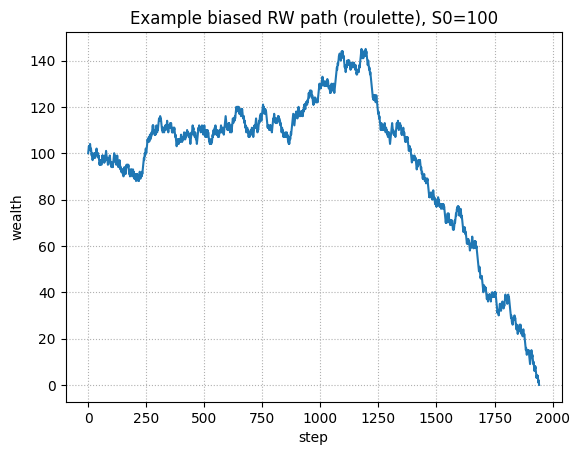

(4.4b) Estimated P_reach_200_before_0 | S0=100 (N=100): 0.000000


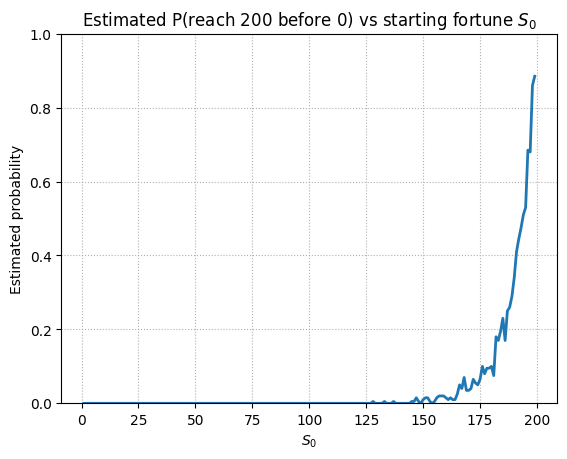

In [14]:
# Imports & global RNG helper
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

def rng(seed: int):
    return np.random.default_rng(seed)
from dataclasses import dataclass
@dataclass
class Config:
    # Monte Carlo sizes for (4.4)
    n_paths_S0_eq_100: int = 100   # part (b)
    n_trials_per_S0: int   = 200   # part (c)
    p_up: float       = 18/38
    lower: int        = 0
    upper: int        = 200
    max_steps_rw: int = 5_000

    # Monte Carlo sizes for (4.4)
    n_paths_S0_eq_100: int = 100   # part (b)
    n_trials_per_S0: int   = 200

    seed: int = 42

CFG = Config()

def sample_rw_absorb(S0: int, p: float, lower: int, upper: int, max_steps: int, g) -> bool:
    S = S0
    for _ in range(max_steps):
        step = 1 if g.random() < p else -1
        S += step
        if S >= upper:
            return True
        if S <= lower:
            return False
    return False

g = rng(CFG.seed + 2)
p = CFG.p_up
upper, lower = CFG.upper, CFG.lower

S = 100
S_vals = [S]
for _ in range(CFG.max_steps_rw):
    S += 1 if g.random() < p else -1
    S_vals.append(S)
    if S <= lower or S >= upper:
        break
plt.figure()
plt.plot(S_vals)
plt.title('Example biased RW path (roulette), S0=100')
plt.xlabel('step'); plt.ylabel('wealth'); plt.grid(True, which='both', linestyle=':'); plt.show()

# (b) Probability to hit 200 before 0 from S0=100
g_b = rng(CFG.seed + 3)
hits = 0
for _ in range(CFG.n_paths_S0_eq_100):
    hits += sample_rw_absorb(100, p, lower, upper, CFG.max_steps_rw, g_b)
prob_from_100 = hits / CFG.n_paths_S0_eq_100
print(f"(4.4b) Estimated P_reach_200_before_0 | S0=100 (N={CFG.n_paths_S0_eq_100}): {prob_from_100:.6f}")

# (c) Probability vs starting fortune S0
S0_vals = np.arange(1, upper)
probs = np.zeros_like(S0_vals, dtype=float)
for i, S0 in enumerate(S0_vals):
    g_c = rng(CFG.seed + 1000 + i)
    hits = 0
    for _ in range(CFG.n_trials_per_S0):
        hits += sample_rw_absorb(S0, p, lower, upper, CFG.max_steps_rw, g_c)
    probs[i] = hits / CFG.n_trials_per_S0

plt.figure()
plt.plot(S0_vals, probs, linewidth=2)
plt.title('Estimated P(reach $200$ before $0$) vs starting fortune $S_0$')
plt.xlabel('$S_0$'); plt.ylabel('Estimated probability'); plt.ylim(0, 1)
plt.grid(True, which='both', linestyle=':'); plt.show()
